In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import joblib
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import zscore
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors


In [2]:
# Carregar o dataset
df_salario = pd.read_csv('./datasets/dataset_salario.csv')

In [3]:
# Inspecionar a estrutura do dataframe
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [4]:
# copiar o DF EDA
df_salario_eda = df_salario.copy()

In [5]:
# copiar o DF Bucketing
df_salario_bucketing = df_salario.copy()

### EDA

In [6]:
# Visualizar os dados
df_salario_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [7]:
# Detectar valores ausentes
df_salario_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [8]:
# Medidas Estatísticas do DF
df_salario_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

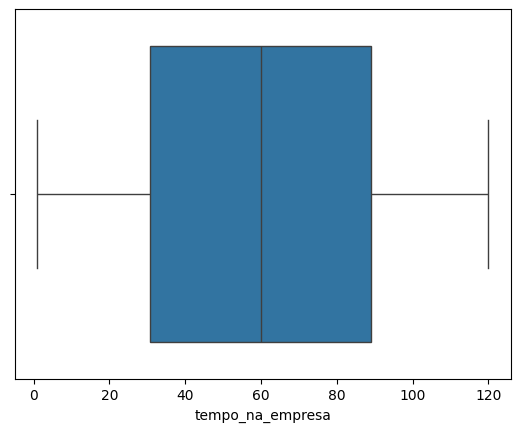

In [9]:
# Verificar / detectar outliers
sns.boxplot(data=df_salario_eda, x=df_salario_eda['tempo_na_empresa'])

<Axes: xlabel='nivel_na_empresa'>

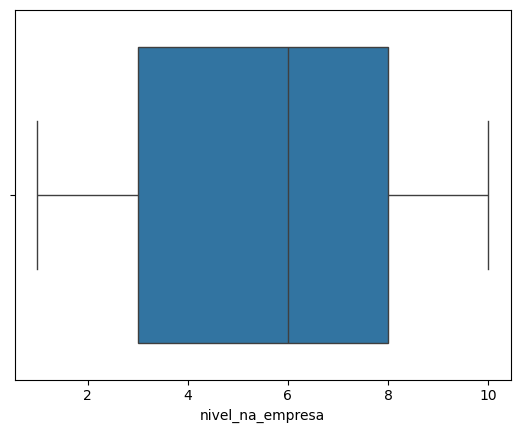

In [10]:
sns.boxplot(data=df_salario_eda, x=df_salario_eda['nivel_na_empresa'])

<Axes: xlabel='salario_em_reais'>

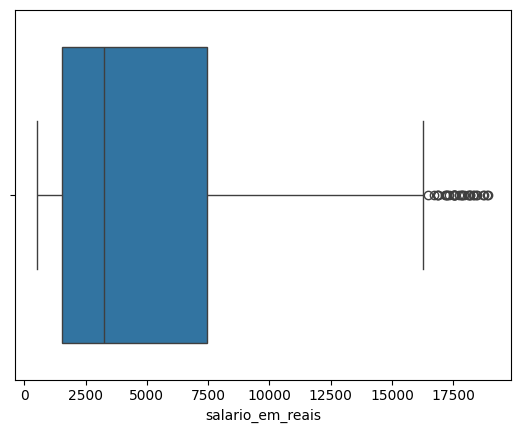

In [11]:
sns.boxplot(data=df_salario_eda, x=df_salario_eda['salario_em_reais'])

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

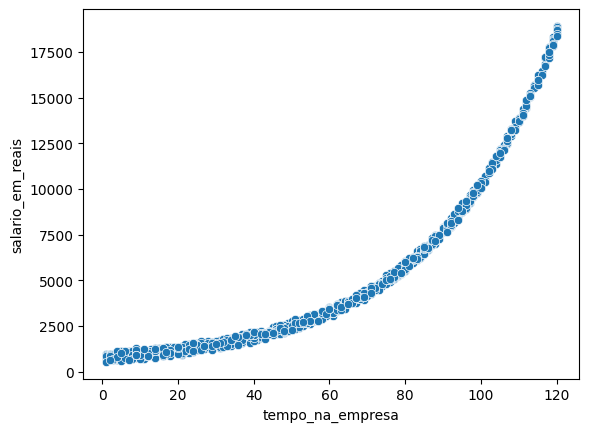

In [12]:
# Cruzamento variáveis númericas com salario em reais (variavel depente)
sns.scatterplot(data=df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

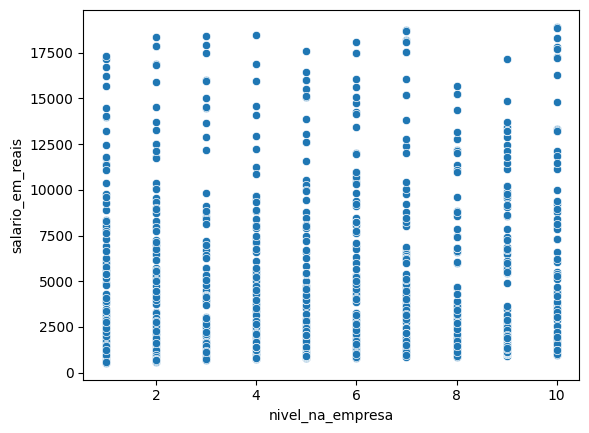

In [13]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

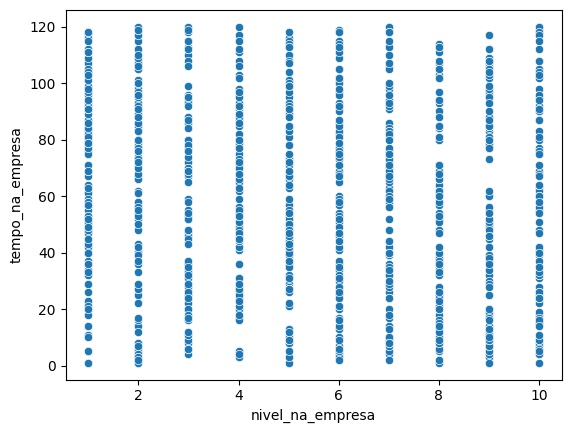

In [14]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='tempo_na_empresa')

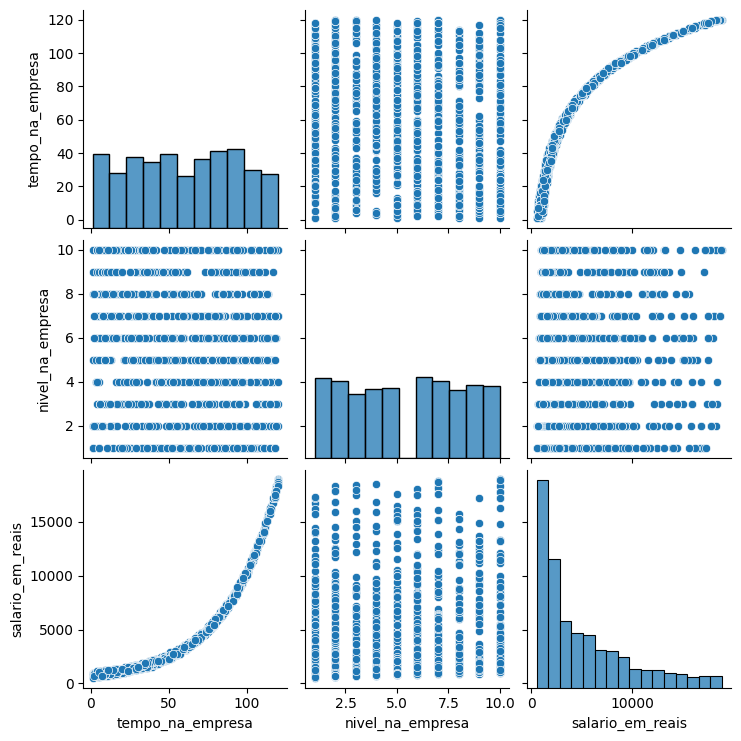

In [15]:
# Histograma das variaveis
sns.pairplot(df_salario_eda)

<Axes: >

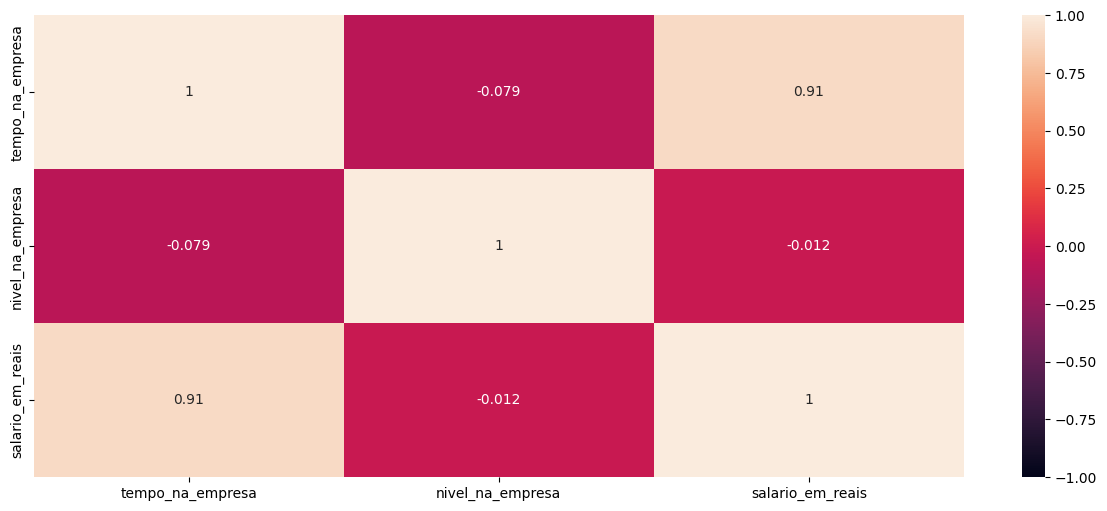

In [16]:
# Diagrama de Correlação com Mapa de Calor - default pearson
plt.figure(figsize=(15,6))
sns.heatmap(df_salario_eda.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

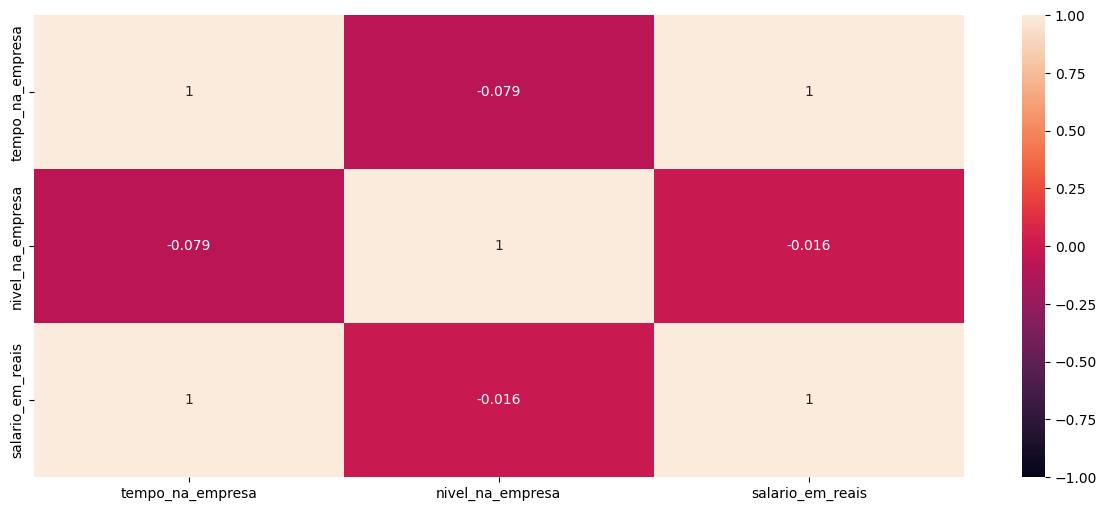

In [17]:
# Diagrama de Correlação com Mapa de Calor - spearman
plt.figure(figsize=(15,6))
sns.heatmap(df_salario_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

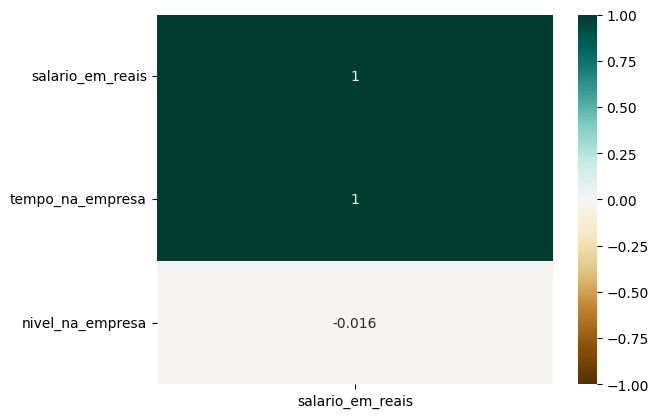

In [18]:
# Formato de Ranking
sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [19]:
# Bucketing Tempo de Casa
bins_tempo_casa = [0, 10,20,30,40,50,60,70,80,90,100,110,120]
labels_tempo_casa = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80-89', '90-99', '100-109', '110-119']

df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)

In [20]:
df_salario_bucketing.head(20)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

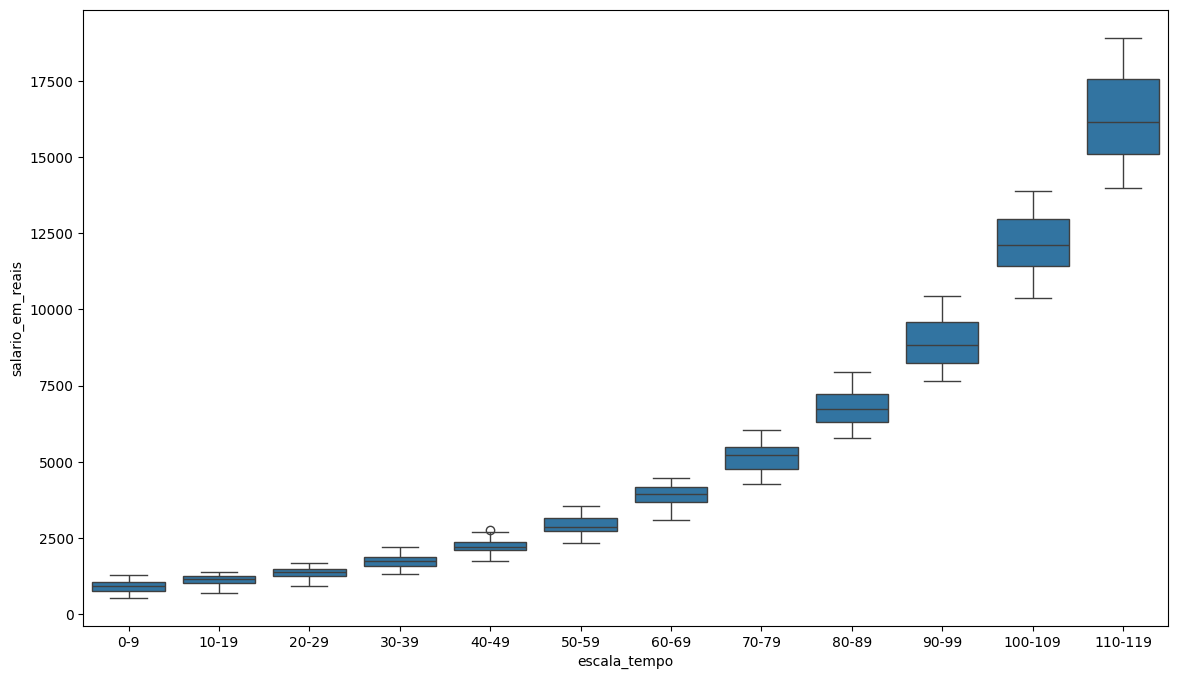

In [21]:
plt.figure(figsize=(14,8))
sns.boxplot(df_salario_bucketing, x='escala_tempo', y='salario_em_reais')

### Treinar Modelo Linear

In [22]:
# Criar o Dataset de Treino e Teste
X = df_salario.drop(columns='salario_em_reais', axis=1)
y = df_salario['salario_em_reais']

In [23]:
# Split usando kFold com 5pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [27]:
# Bloco para Treinamento do Modelo

# PipeLine
# Padronizar variáveis numéricas - tempo_na_empresa, nivel_na_empresa

#Nomes das Colunas
colunas_numericas =['tempo_na_empresa', 'nivel_na_empresa']

# Transformer para Colunas Númericas

transformers_numericas = Pipeline(steps=[('scaler', StandardScaler())])

# Criar um ColumnTransformer
preprocessor = ColumnTransformer(
  transformers=[
    ('num', transformers_numericas, colunas_numericas)
  ]
)

# Criando o Pipeline principal = Pré-Processamento + Treinamento
model_regr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

# Armazenar RMSE Treino e Teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 Score de Teste
r2_score_fold_test = []

# Armazenar Resíduos
residuos = []

# Armazernar Predições
y_pred_total = []


for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # Treine o modelo no conjunto de treinamento
  model_regr.fit(X_train, y_train)

  # Faça predições nos conjuntos de treinamento e teste
  y_train_pred = model_regr.predict(X_train)
  y_test_pred = model_regr.predict(X_test)

  # Calcule o RMSE para os conjuntos de treinamento e teste
  rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
  rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
  
  # Calcula o R2Score e Residuos para o conjunto de teste
  r2score_test = r2_score(y_test, y_test_pred)
  residuos_test = np.array(y_test - y_test_pred)

  # Armazena as metricas da interação na lista
  rmse_scores_fold_train.append(rmse_train)
  rmse_scores_fold_test.append(rmse_test)
  r2_score_fold_test.append(r2score_test)
  residuos.append(residuos_test)
  y_pred_total.append(y_test_pred)


rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_test_final = np.mean(r2_score_fold_test)
percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)


### Análise de Métricas - Modelo Linear

In [29]:
# Métricas
print(f'RMSE TREINO: {rmse_train_final}')
print(f'RMSE TESTE: {rmse_test_final}')
print(f'% Diferença Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')

RMSE TREINO: 1882.8318426651392
RMSE TESTE: 1886.4504221336076
% Diferença Treino e Teste: 0.19218813844503052
R2Score Teste: 0.8261178870584761


### Análise de Resíduos - Modelo Linear

In [32]:
# Transformar residuos na escala padrão
# (X - media) /desvio_padrão

residuos_std = zscore(residuos)

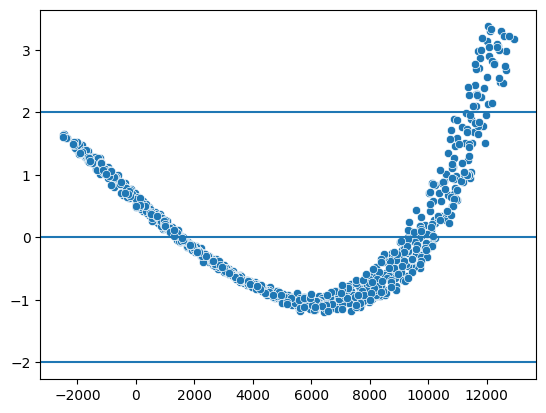

In [34]:
# Verificar linearidade dos resíduos: Valores entre -2 e +2 (Escala Padrão)
# Verificar homocedasticidade: Valores em torno da reta sem nenhuma tendência ou formato

sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)


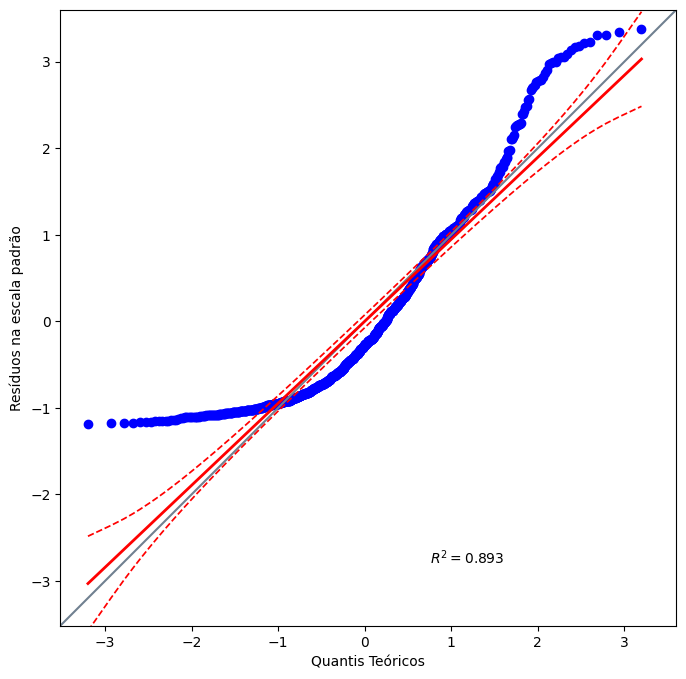

In [37]:
# Checar se resíduos seguem uma distribuição normal
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [41]:
# Teste de Normalidade - Shapiro-Wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f"Estatistica Teste {stat_shapiro} e P-Value {p_value_shapiro}")

Estatistica Teste 0.891970157623291 e P-Value 7.015059614730555e-26


In [43]:
# Teste de Normalidade - Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f"Estatistica Teste {stat_ks} e P-Value {p_value_ks}")

Estatistica Teste 0.5939999999999955 e P-Value 0.0


In [45]:
# Teste de Normalidade - Lillieforms
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f"Estatistica Teste {stat_ll} e P-Value {p_value_ll}")

Estatistica Teste 0.11825983774680088 e P-Value 0.0009999999999998899


### Treinar Modelo Polinominal

In [46]:
# Exemplo de criação de Features Polinomias
feat_poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [48]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [54]:
# Bloco para Treinamento do Modelo

#graus_polymonial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
graus_polymonial = [4]


rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2_score_test_values = []

# Split usando kFold com 5pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polymonial:


  # PipeLine
  # Padronizar variáveis numéricas - tempo_na_empresa, nivel_na_empresa

  #Nomes das Colunas
  colunas_numericas =['tempo_na_empresa', 'nivel_na_empresa']

  # Transformer para Colunas Númericas

  transformers_numericas = Pipeline(steps=[('scaler', StandardScaler())])

  # Criar um ColumnTransformer
  preprocessor = ColumnTransformer(
    transformers=[
      ('num', transformers_numericas, colunas_numericas)
    ]
  )

  # Criar Features Polinomiais
  poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

  # Criando o Pipeline principal = Pré-Processamento + Treinamento
  model_poly = Pipeline(steps=[('preprocessor', preprocessor),('poly_features', poly_feat) ,('regressor', LinearRegression())])

  # Armazenar RMSE Treino e Teste
  rmse_scores_fold_train = []
  rmse_scores_fold_test = []

  # Armazenar R2 Score de Teste
  r2_score_fold_test = []

  # Armazenar Resíduos
  residuos = []

  # Armazernar Predições
  y_pred_total = []


  for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treine o modelo no conjunto de treinamento
    model_poly.fit(X_train, y_train)

    # Faça predições nos conjuntos de treinamento e teste
    y_train_pred = model_poly.predict(X_train)
    y_test_pred = model_poly.predict(X_test)

    # Calcule o RMSE para os conjuntos de treinamento e teste
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Calcula o R2Score e Residuos para o conjunto de teste
    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    # Armazena as metricas da interação na lista
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2_score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)


  rmse_train_final = np.mean(rmse_scores_fold_train)
  rmse_test_final = np.mean(rmse_scores_fold_test)
  r2score_test_final = np.mean(r2_score_fold_test)
  percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
  residuos = np.array(residuos).reshape(-1)
  y_pred_total = np.array(y_pred_total).reshape(-1)

  rmse_train_values.append(rmse_train_final)
  rmse_test_values.append(rmse_test_final)
  r2_score_test_values.append(r2score_test_final)
  percentual_rmse_values.append(percentual_rmse_final)


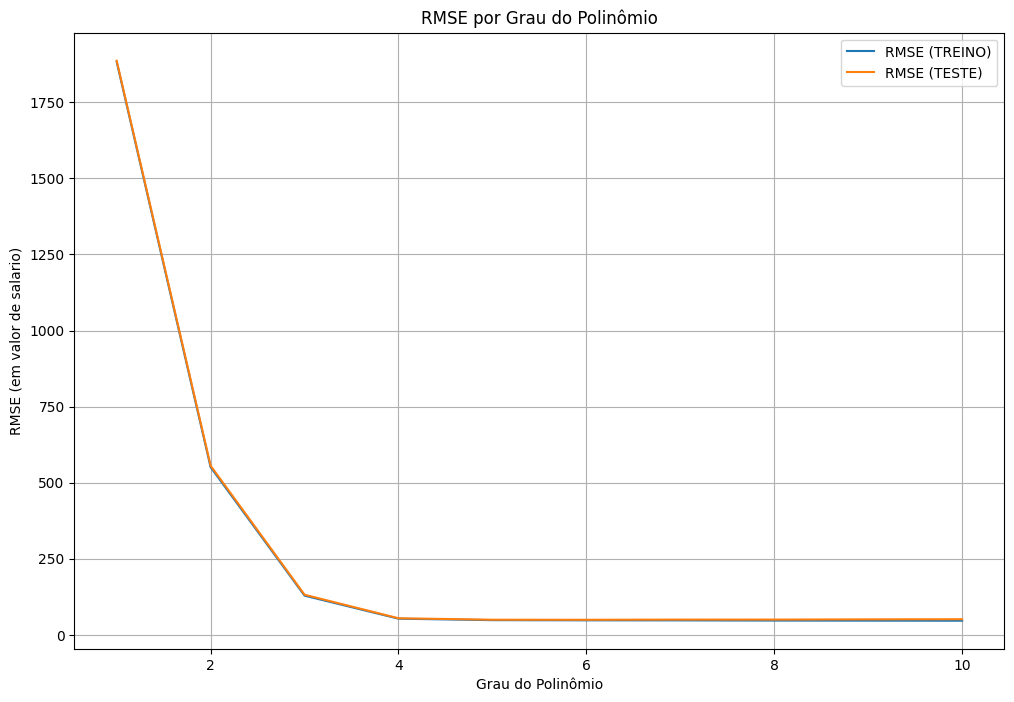

In [52]:
# Plotar Gráfico para comparar RMSE por Grau de Polinômio
plt.figure(figsize=(12,8))
plt.plot(graus_polymonial, rmse_train_values, label="RMSE (TREINO)")
plt.plot(graus_polymonial, rmse_test_values, label="RMSE (TESTE)")
plt.xlabel('Grau do Polinômio')
plt.ylabel('RMSE (em valor de salario)')
plt.title('RMSE por Grau do Polinômio')
plt.legend()
plt.grid(True)
plt.show()

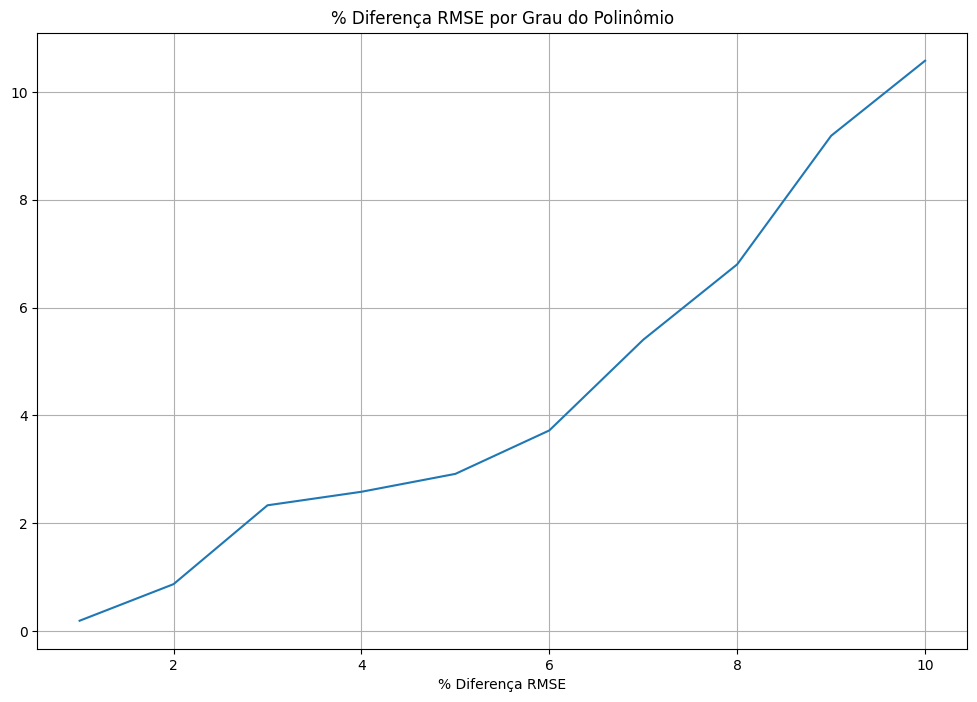

In [53]:
# Plotar Gráfico para comparar % de diferença de RMSE (TREINO E TESTE)
plt.figure(figsize=(12,8))
plt.plot(graus_polymonial, percentual_rmse_values, label="% Diferença Treino e Teste")
plt.xlabel('Grau do Polinômio')
plt.xlabel('% Diferença RMSE')
plt.title('% Diferença RMSE por Grau do Polinômio')
plt.grid(True)
plt.show()

### Analise de Métricas - Modelo Polinômial

In [55]:
# Métricas
print(f'RMSE TREINO: {rmse_train_final}')
print(f'RMSE TESTE: {rmse_test_final}')
print(f'% Diferença Treino e Teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')

RMSE TREINO: 53.326985595651614
RMSE TESTE: 54.7050435279633
% Diferença Treino e Teste: 2.584166190755124
R2Score Teste: 0.9998524123039415


### Análise de Resíduos - Modelo Polinomial

In [57]:
# Transformar residuos na escala padrão
# (X - media) /desvio_padrão

residuos_std = zscore(residuos)

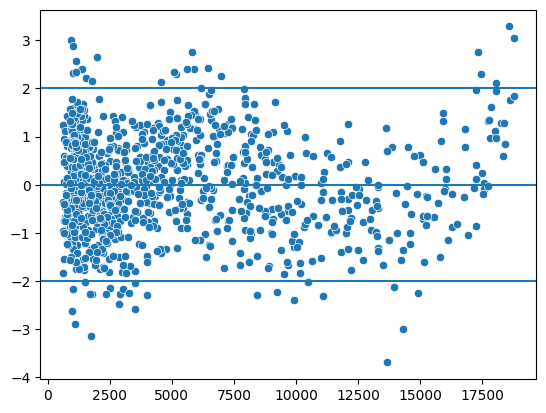

In [58]:
# Verificar linearidade dos resíduos: Valores entre -2 e +2 (Escala Padrão)
# Verificar homocedasticidade: Valores em torno da reta sem nenhuma tendência ou formato

sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

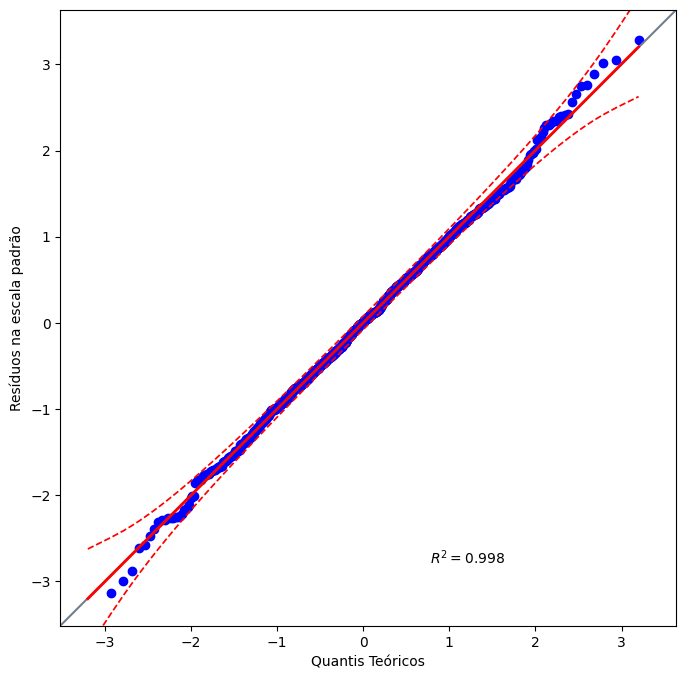

In [59]:
# Checar se resíduos seguem uma distribuição normal
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [60]:
# Teste de Normalidade - Shapiro-Wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f"Estatistica Teste {stat_shapiro} e P-Value {p_value_shapiro}")

Estatistica Teste 0.9986947774887085 e P-Value 0.6850231289863586


In [61]:
# Teste de Normalidade - Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f"Estatistica Teste {stat_ks} e P-Value {p_value_ks}")

Estatistica Teste 0.48237446499542513 e P-Value 1.2202460103427783e-214


In [62]:
# Teste de Normalidade - Lillieforms
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f"Estatistica Teste {stat_ll} e P-Value {p_value_ll}")

Estatistica Teste 0.013637346894987523 e P-Value 0.9566270022044202


## Realizar Predições individuais

In [71]:
input_features = {
  'tempo_na_empresa': 12,
  'nivel_na_empresa': 1
}

pred_df = pd.DataFrame(input_features, index=[1])

In [72]:
#Predição
model_poly.predict(pred_df)

array([737.45831047])

In [75]:
# Salvar Modelo
joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']